# 缠论编程实现

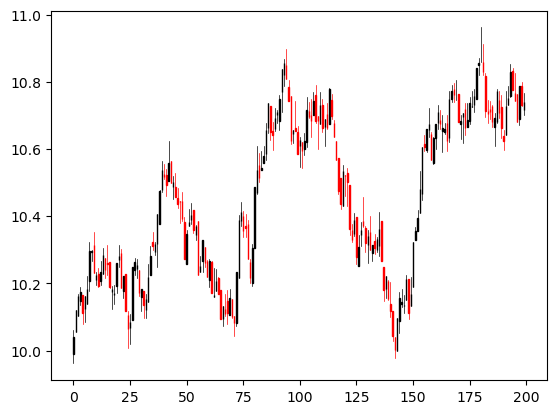

In [9]:
# 随机生成 1min KLine 作为example

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

N = 200
px = (1+ np.cumsum(np.random.normal(0, 0.0015, 20 * N))) * 10
px = pd.Series(px)
opn = px.groupby(px.index // 20).first()
cls = px.groupby(px.index // 20).last()
hgh = px.groupby(px.index // 20).max()
low = px.groupby(px.index // 20).min()
ts = pd.Series(opn.index)

df_kline = pd.concat([ts.rename('time'), opn.rename('open'), hgh.rename('high'), low.rename('low'), cls.rename('close')], axis=1)

# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_kline.values)

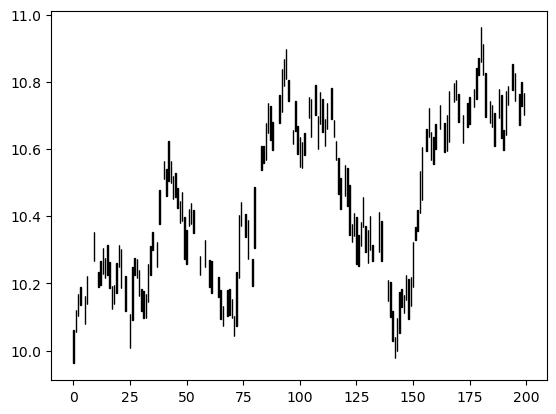

In [10]:
# 缠论 K 线

n = len(df_kline)

cklines = []

for i in range(n):
    t,low,hgh = df_kline.iloc[i][['time','low','high']]
    if len(cklines) == 0:
        cklines.append((t,low,hgh))
    elif len(cklines) == 1:
        pt, plow, phgh = cklines[-1]
        if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh):
            cklines[-1] = (t, max(plow,low), max(phgh, hgh))
        else:
            cklines.append((t,low,hgh))
    else:
        pt, plow, phgh = cklines[-1]
        if cklines[-1][2] > cklines[-2][2]: # up
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # up-up merge
                cklines[-1] = (t, max(plow,low), max(phgh, hgh))
            else:
                cklines.append((t, low, hgh))
 
        else: # down
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # low-low merge
                cklines[-1] = (t, min(plow,low), min(phgh, hgh))
            else:
                cklines.append((t, low, hgh))

# 缠论 K 线
df_ckline = pd.DataFrame(data=cklines, columns=['time','low','high'])

# 添加open/close只是为了作图
df_ckline['open'] = df_ckline['low']
df_ckline['close'] = df_ckline['high']


# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_ckline.values)

In [11]:
# 顶/底分型

parts = []
for i in range(1, len(df_ckline)-1):
    plow, phgh = df_ckline.iloc[i-1][['low','high']]
    t, low, hgh = df_ckline.iloc[i][['time','low','high']]
    nlow, nhgh = df_ckline.iloc[i+1][['low','high']]

    if hgh > phgh and hgh > nhgh: # 顶分型
        parts.append((1,t,low,hgh))
    elif hgh < phgh and hgh < nhgh: # 底分型
        parts.append((-1,t,low,hgh))

df_part = pd.DataFrame(data=parts, columns=('type','time','low','high'))
df_part

,type,time,low,high
0,1,3.0,10.135593,10.190212
1,-1,5.0,10.080320,10.163724
2,1,9.0,10.268095,10.352494
3,-1,11.0,10.188534,10.233146
4,1,13.0,10.228910,10.304529
...,...,...,...,...
66,1,188.0,10.691783,10.780029
67,-1,190.0,10.598637,10.657802
68,1,194.0,10.775637,10.854074
69,-1,197.0,10.672061,10.765431


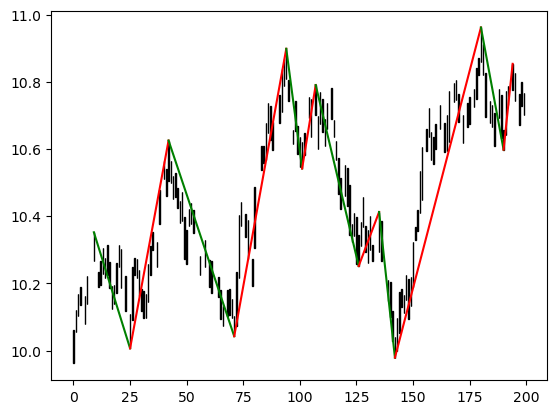

In [12]:
# 笔

biparts = []
for i in range(len(parts)):
    typ, t, low, hgh = parts[i]
    if len(biparts) == 0:
        biparts.append(parts[i])
    else:
        ptyp, pt, plow, phgh = biparts[-1]

        if (ptyp != typ) and (t-pt >= 4):
            biparts.append(parts[i])

        elif (ptyp == typ == 1) and (hgh >= phgh):
            biparts[-1] = parts[i]

        elif (ptyp == typ == -1) and (low <= plow):
            biparts[-1] = parts[i]


bis = []
for i in range(1, len(biparts)):
    typ0, t0, low0, hgh0 = biparts[i-1]
    typ1, t1, low1, hgh1 = biparts[i]

    px0 = low0 if typ0 == -1 else hgh0 
    px1 = low1 if typ1 == -1 else hgh1
    
    bis.append((t0, t1, px0, px1))

df_bi = pd.DataFrame(data=bis, columns=['t0','t1','px0','px1'])


# plot
fig,ax = plt.subplots()
_ = candlestick_ohlc(ax, df_ckline.values)
for t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],color='r' if px1>px0 else 'g')
